In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import string
import math 
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. Exploring and Cleaning up the Data

Import the train and test data sets, extract the survival column from train data and combine the two datasets. We replace the two missing values for the *Embarked* column with the most common value *'S'*. The missing *Cabin* values are replaced by *'Unknown'*. The single missing *Fare* is replaced by the mean according to the *Pclass* column.

In [29]:
# load the data sets
train_data=pd.read_csv("/kaggle/input/titanic/train.csv")
test_data=pd.read_csv("/kaggle/input/titanic/test.csv")

# create survival columns
y = train_data['Survived']

# merge data sets and drop PassengerID
full = pd.concat(
    [
        train_data.drop(['PassengerId'], axis=1), 
        test_data.drop(['PassengerId'], axis=1),
    ]
)

# reset index
full = full.reset_index(drop=True)

print(full.info())
print(full['Embarked'].value_counts())

# fill NaNs
full['Embarked'] = full.Embarked.fillna('S')
full['Cabin'] = full.Cabin.fillna('Unknown')


print(full[full['Fare'].isnull()])
print(full[full['Pclass'] == 1]['Fare'].mean())
print(full[full['Pclass'] == 2]['Fare'].mean())
print(full[full['Pclass'] == 3]['Fare'].mean())
full['Fare']= full.Fare.fillna(13.3028)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 112.6+ KB
None
S    914
C    270
Q    123
Name: Embarked, dtype: int64
      Survived  Pclass                Name   Sex   Age  SibSp  Parch Ticket  \
1043       NaN       3  Storey, Mr. Thomas  male  60.5      0      0   3701   

      Fare    Cabin Embarked  
1043   NaN  Unknown        S  
87.50899164086688
21.1791963898917
13.30

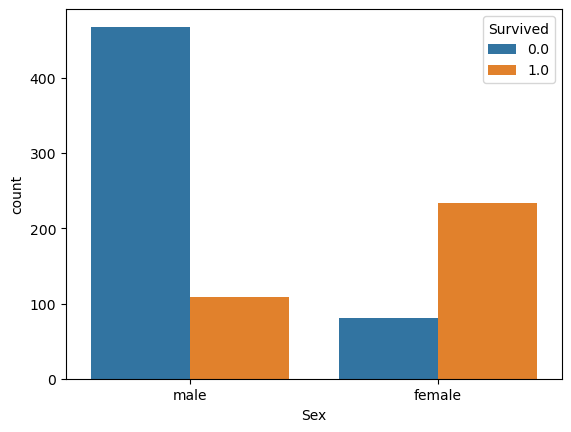

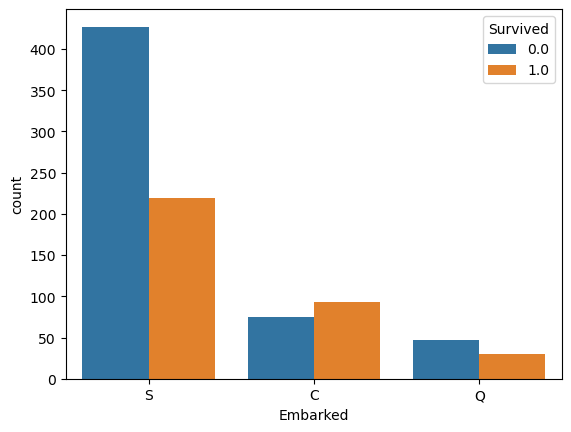

<Axes: xlabel='Pclass', ylabel='count'>

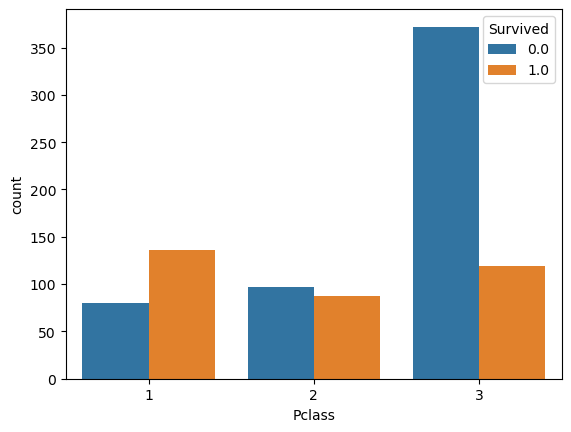

In [30]:
# Plot Sex/Embarked/Plcass survival counts
sns.countplot(data=full, x='Sex', hue='Survived')
plt.show()
sns.countplot(data=full, x='Embarked', hue='Survived')
plt.show()
sns.countplot(data=full, x='Pclass', hue='Survived')

# 2. Feature Engineering
The *Name* column contains interesting information, namely the title. We create a new column *Title* containing this information. We the replace the missing values for *Age* by the median according to *Title*. Finally, we group the titles into four categories and realize that these categories affect survival significantly.

                  Age
Sex    Title         
female Countess  33.0
       Don       39.0
       Dr        49.0
       Miss      22.0
       Mlle      24.0
       Mme       24.0
       Mrs       35.0
       Ms        28.0
male   Capt      70.0
       Col       54.5
       Don       40.0
       Dr        47.0
       Jonkheer  38.0
       Major     48.5
       Master     4.0
       Mr        29.0
       Rev       41.5


<Axes: xlabel='Title', ylabel='count'>

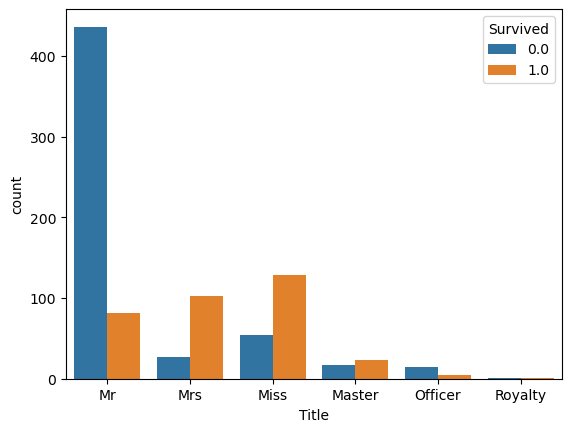

In [31]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    print(big_string)
    return np.nan

# list of titles
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

# create Title column and fill it with titles
full['Title']=full['Name'].map(lambda x: substrings_in_string(x, title_list))


# look at median ages by title
AgeEstimate = full[['Age','Title','Sex']].groupby(['Sex','Title']).median()
print(AgeEstimate)


# replace missing ages by title
def age_replace(x):
    age=x['Age']
    title=x['Title']
    if math.isnan(age):
        if (title == 'Don' and x['Sex']=='female'):
            return 29.0
        elif (title == 'Dr' and x['Sex']=='female'):
            return 49.0
        elif title == 'Countess':
            return 33.0
        elif title == 'Miss':
            return 22.0
        elif title == 'Mlle':
            return 24.0     
        elif title == 'Mrs':
            return 35.0
        elif title == 'Mme':
            return 24.0
        elif title == 'Ms':
            return 28.0
        elif title == 'Capt':
            return 70.0
        elif title == 'Col':
            return 54.5
        elif (title == 'Dr' and x['Sex']=='male'):
            return 47.0
        elif (title == 'Don' and x['Sex']=='male'):
            return 40.0
        elif title == 'Jonkheer':
            return 38.0
        elif title == 'Master':
            return 4.0
        elif title == 'Mr':
            return 29.0
        elif title == 'Rev':
            return 41.5
    else:
        return age
    
full['Age']=full.apply(age_replace, axis=1)

# group titles
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Dr', 'Rev', 'Col']:
        return 'Officer'
    elif title in ['Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title in ['Countess', 'Jonkheer', 'Don']:
        return 'Royalty'
    else:
        return title
    
full['Title']=full.apply(replace_titles, axis=1)
full = full.drop(['Name'], axis=1)

# How does the title affect survival?
sns.countplot(data=full, x='Title', hue='Survived')

The columns *SibSp* and *Parch* can be used to create a new variable *Family_Size* which in turn is used to create other related variables. We also use it to create the variable *Fare_Per_Person*. We extract the *Ticket_Number* from the *Ticket* column.

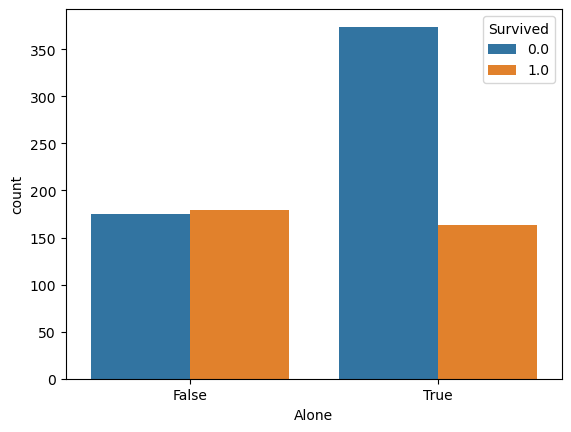

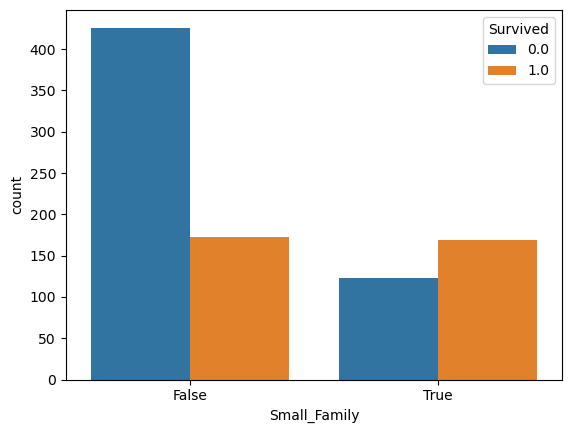

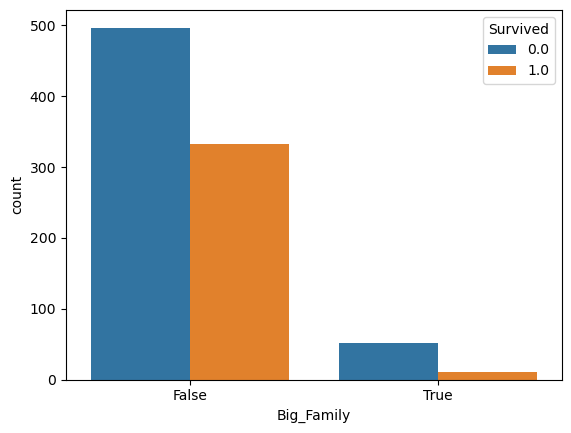

In [32]:
# add family size and related variables as well as fare per person
full['Family_Size']=full['SibSp']+full['Parch']+1
full['Alone'] = full['Family_Size'].apply(lambda x: 1 if x == 1 else 0).astype(bool)
full['Small_Family']= full['Family_Size'].apply(lambda x: 1 if 2<=x<=4 else 0).astype(bool)
full['Big_Family']= full['Family_Size'].apply(lambda x: 1 if 5<=x else 0).astype(bool)
full['Fare_Per_Person']=full['Fare']/(full['Family_Size'])

sns.countplot(data=full, x='Alone', hue='Survived')
plt.show()

sns.countplot(data=full, x='Small_Family', hue='Survived')
plt.show()

sns.countplot(data=full, x='Big_Family', hue='Survived')
plt.show()

# extract Ticket_Number from Ticket
full['Ticket_Number'] = full['Ticket'].str.split()
full['Ticket_Number'] = full['Ticket_Number'].str[-1]
full['Ticket_Number'] = LabelEncoder().fit_transform(full['Ticket_Number'])
full = full.drop(['Ticket'], axis=1)

We analyze the effect of *Fare* and *Age* by creating appropriate bins.

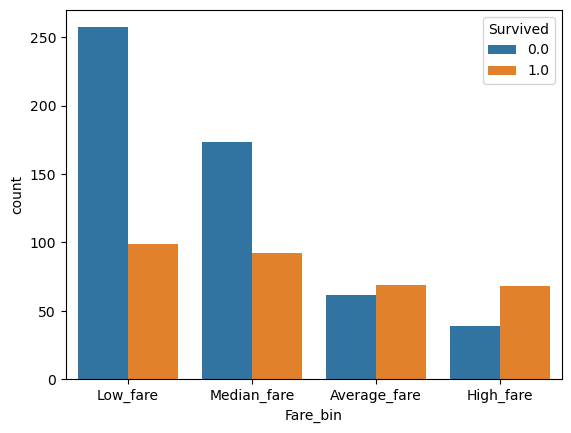

<Axes: xlabel='Age_bin', ylabel='count'>

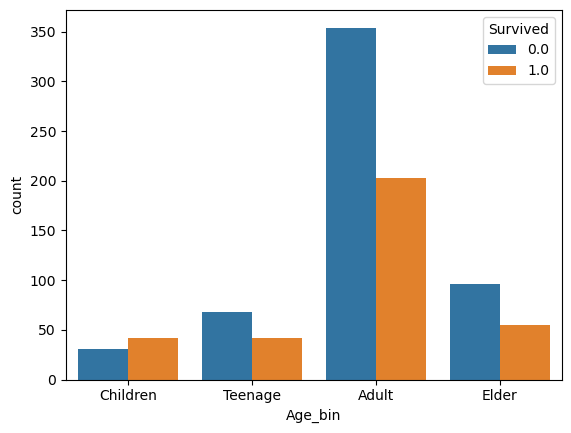

In [33]:
# consider age and fare bins
full['Age_bin'] = pd.cut(full['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
full['Fare_bin'] = pd.cut(full['Fare_Per_Person'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','Median_fare','Average_fare','High_fare'])
full.head()

sns.countplot(data=full, x='Fare_bin', hue='Survived')
plt.show()
sns.countplot(data=full, x='Age_bin', hue='Survived')

We create a variable *Deck_Known* and look at its effect on survival.

<Axes: xlabel='Deck_Known', ylabel='count'>

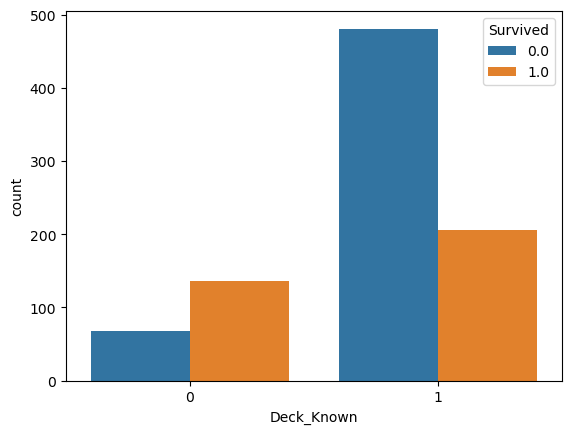

In [34]:
# extract the deck from cabin and create variable Deck_Known
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
full['Deck']=full['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
full['Deck_Known']=full['Deck'].map(lambda x: 1 if x=='Unknown' else 0)

sns.countplot(data=full, x='Deck_Known', hue='Survived')

# 3. Feature Selection
We begin by analyzing the features using a heatmap and drop various highly correlated features. We scale the data and perform a train/test split.

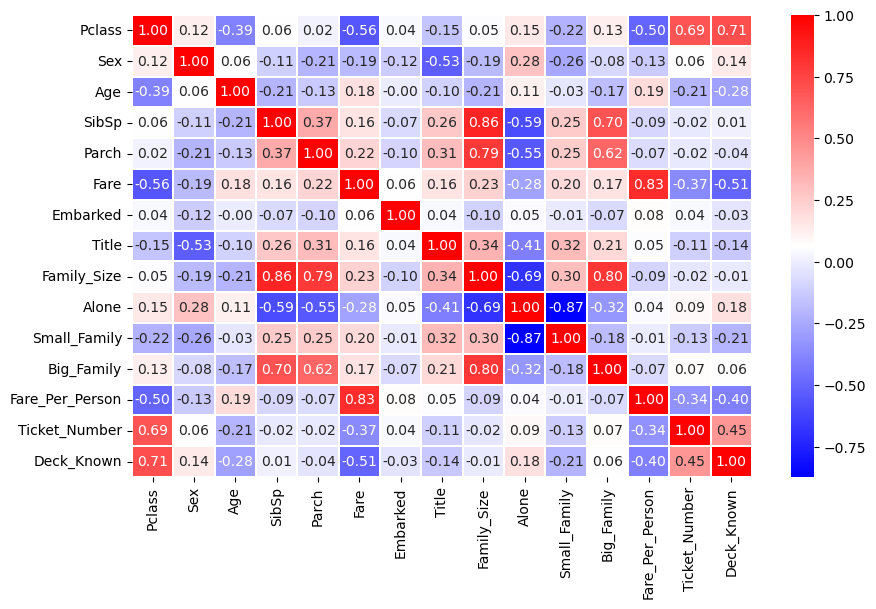

   Pclass    Sex  Embarked  Title  Family_Size  Alone   Age  Fare_Per_Person  \
0       3   True         0      0            2  False  22.0          3.62500   
1       1  False         1      2            2  False  38.0         35.64165   
2       3  False         0      1            1   True  26.0          7.92500   
3       1  False         0      2            2  False  35.0         26.55000   
4       3   True         0      0            1   True  35.0          8.05000   

   Ticket_Number  Deck_Known  
0            209           1  
1            166           0  
2            466           1  
3             67           0  
4            832           1  


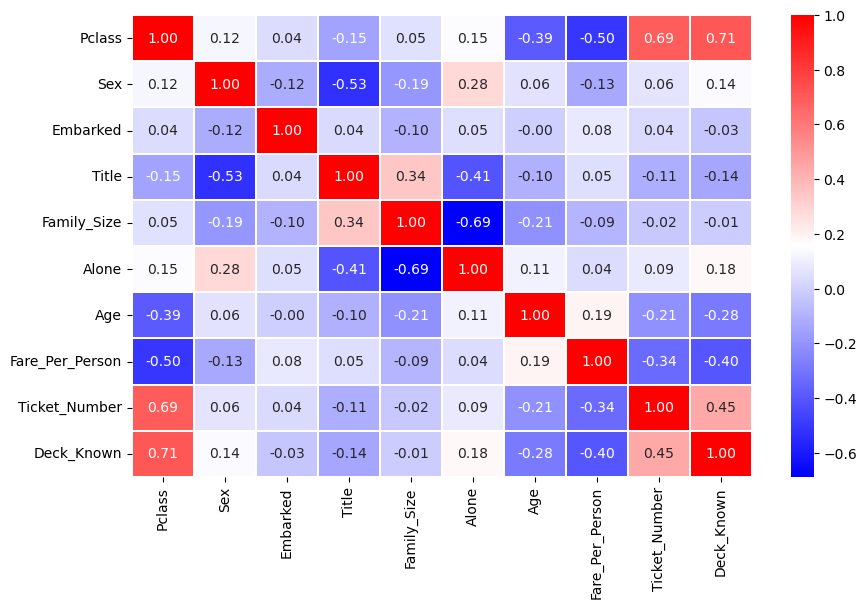

     Pclass       Sex  Embarked     Title  Family_Size     Alone       Age  \
0  0.841916  0.743497 -0.603436 -0.716193     0.073352 -1.233758 -0.564224   
1 -1.546098 -1.344995  0.927373  1.241003     0.073352 -1.233758  0.652320   
2  0.841916 -1.344995 -0.603436  0.262405    -0.558346  0.810532 -0.260088   
3 -1.546098 -1.344995 -0.603436  1.241003     0.073352 -1.233758  0.424218   
4  0.841916  0.743497 -0.603436 -0.716193    -0.558346  0.810532  0.424218   

   Fare_Per_Person  Ticket_Number  Deck_Known  
0        -0.472416      -0.846179    0.539377  
1         0.423216      -1.004578   -1.853992  
2        -0.352128       0.100529    0.539377  
3         0.168887      -1.369263   -1.853992  
4        -0.348631       1.448759    0.539377  


In [35]:
# Make variables numeric 
full['Sex'] = full['Sex'].map({'male': 1, 'female': 0}).astype(bool)  
full['Embarked']=full['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
full['Title']=full['Title'].map({'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Officer':4, 'Royalty':5}).astype(int)

# drop Survivided Column
full = full.drop(['Survived'], axis=1)

# create heatmap with all features
sns.heatmap(full.corr(numeric_only = True),annot=True,cmap='bwr',fmt='.2f',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

# select features
features = ['Pclass','Sex','Embarked','Title', 'Family_Size','Alone','Age', 'Fare_Per_Person', 'Ticket_Number', 'Deck_Known']
X = full[features]
X = X.copy()
print(X.head())



# heatmap after feature selection
sns.heatmap(X.corr(numeric_only = True),annot=True,cmap='bwr',fmt='.2f',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

# scaling
scaler = StandardScaler()
X.loc[:]= scaler.fit_transform(X)
print(X.head())


# split data again
train = X[:y.shape[0]]
test = X[y.shape[0]:]

# train/test split
train_X, test_X, train_y, test_y = train_test_split(train, y, test_size=0.2, random_state=1,stratify=y)


We perfom a PCA to evaluate our feature selection.

<Axes: >

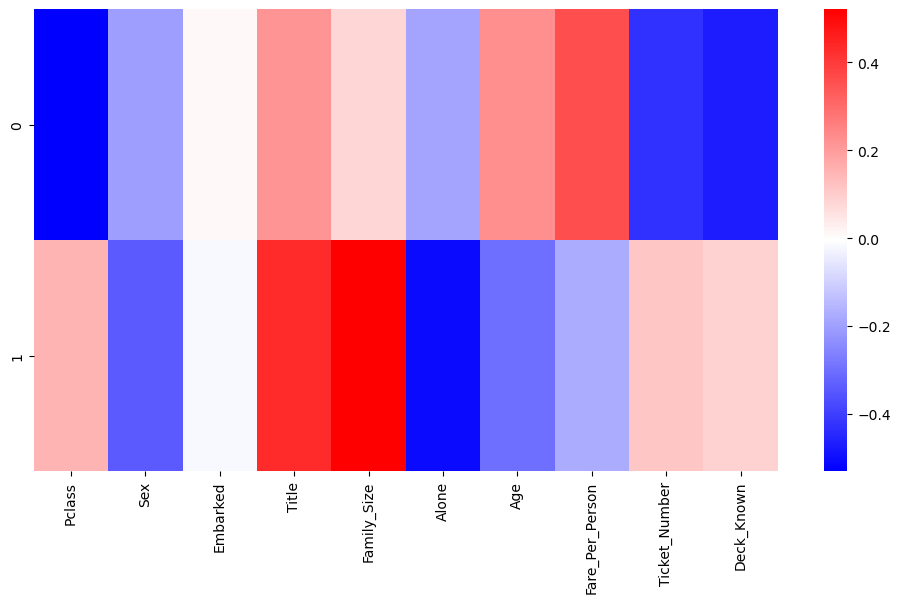

In [36]:
# perform PCA
pca = PCA(n_components=2)
pca.fit(X)

map= pd.DataFrame(pca.components_,columns=X.columns)
plt.figure(figsize=(12,6))
sns.heatmap(map,cmap='bwr')

# 4. Random Forest Model
We use a random forest classifier for our predictions. After the initial prediction, we look at the feature importance as well as partial dependecies to evaluate our feature selection.

Accuracy: 0.8491620111731844
Precision: 0.8181818181818182
Recall: 0.782608695652174


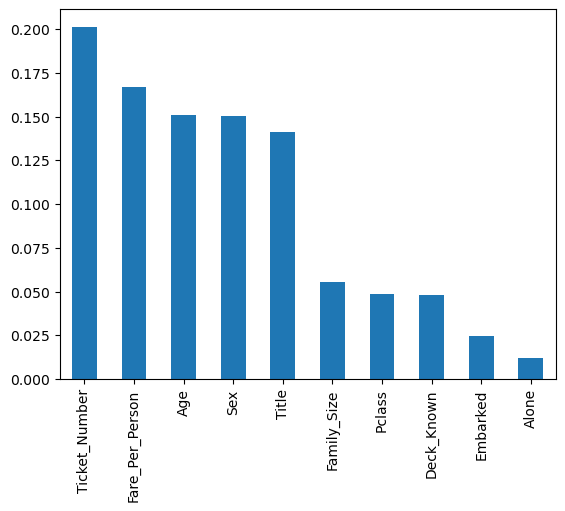

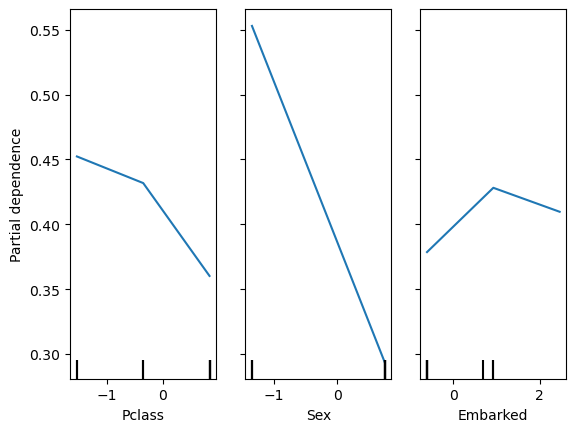

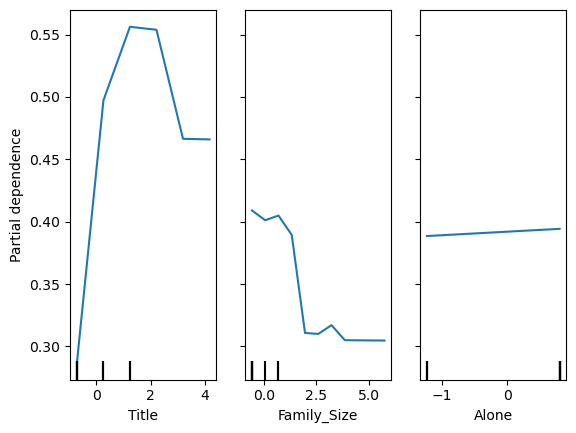

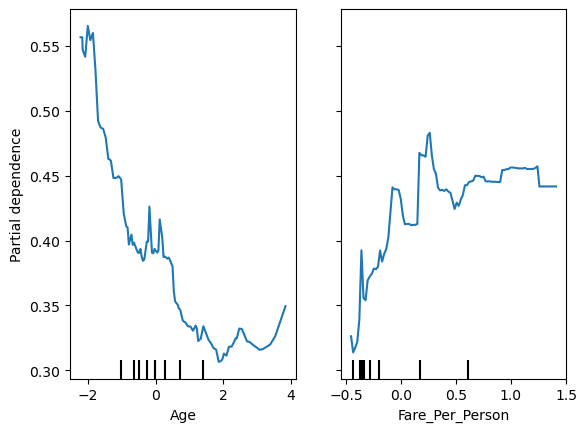

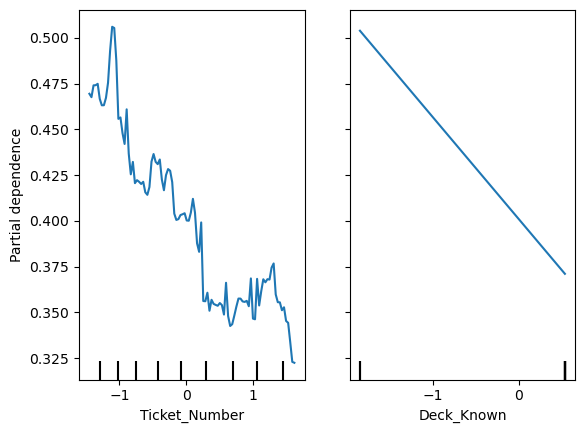

In [37]:
# initialize random forest classifier and fit it with the training data

model = RandomForestClassifier(random_state=1)
model.fit(train_X, train_y)

# predict the test data
pred_y =model.predict(test_X)

# evaluate model performence
accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


# create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)
feature_importances.plot.bar();



# plot partial dependencies
PartialDependenceDisplay.from_estimator(model, X, [0,1,2])
PartialDependenceDisplay.from_estimator(model, X, [3,4,5])
PartialDependenceDisplay.from_estimator(model, X, [6,7])
PartialDependenceDisplay.from_estimator(model, X, [8,9])


# 5. Hyperparameter Tuning
We keep our features in place and perfom hyperparameter tuning using a randomized search.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best hyperparameters: {'max_depth': 15, 'n_estimators': 116}


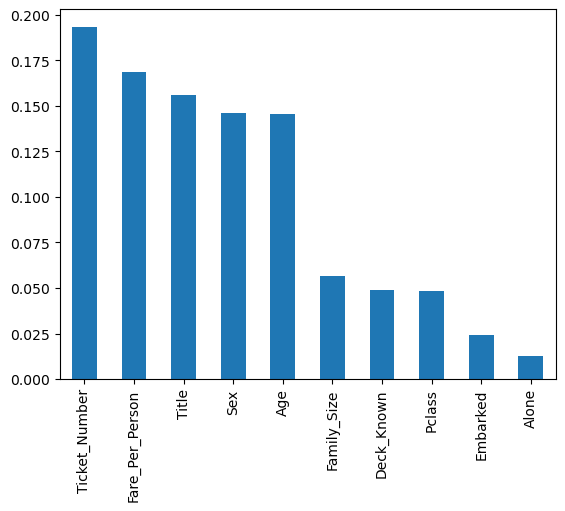

In [38]:
# paramter distribution
param_dist = {'n_estimators': randint(20,200),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=1)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=100, 
                                 cv=5,
                                 n_jobs = -1)


# Fit the random search object to the data
rand_search.fit(train_X, train_y)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)


# create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rand_search.best_estimator_.feature_importances_, index=train_X.columns).sort_values(ascending=False)
feature_importances.plot.bar();


In [39]:
# perform predictions using the random search
pred_y =rand_search.predict(test_X)

accuracy = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall = recall_score(test_y, pred_y)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8491620111731844
Precision: 0.828125
Recall: 0.7681159420289855


# 6. Submission
The final pediction is produced and saved.

In [40]:
# produce final predictions

predictions=rand_search.predict(test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
